In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import pandas as pd


In [2]:
# 1. Load Covertype data
cov = fetch_covtype()
X, y = cov.data, cov.target

In [4]:
X, y = fetch_covtype(return_X_y=True)
df = pd.DataFrame(X, columns=[f"feat_{i}" for i in range(X.shape[1])])
df["target"] = y

# Sample 10% from each class
df_sub = (
    df
    .groupby("target", group_keys=False)
    .apply(lambda grp: grp.sample(frac=0.10, random_state=42))
    .reset_index(drop=True)
)

# Split back into X and y if needed
X_filt = df_sub.drop("target", axis=1).values
y_filt = df_sub["target"].values

print("After filtering:", np.bincount(y_filt).astype(int))

After filtering: [    0 21184 28330  3575   275   949  1737  2051]


/tmp/ipython-input-4-1749060449.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(frac=0.10, random_state=42))


In [5]:
# 3. Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_filt, y_filt,
    test_size=0.2,
    stratify=y_filt,
    random_state=42
)

In [6]:
# 3. Hyper‐parameter grid and search
param_grid = {
    'criterion':        ['gini', 'entropy'],
    'max_depth':        [None, 10, 20, 30],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # you can add 'max_features': ['sqrt','log2', None], etc.
}

dt = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',  # optimize for weighted F1
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best hyper‐parameters found:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyper‐parameters found:
  criterion: gini
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 2


In [7]:
# 4. Evaluate on test set
best_dt = grid.best_estimator_
y_pred = best_dt.predict(X_test)

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall    = recall_score(y_test, y_pred, average='weighted')
f1        = f1_score(y_test, y_pred, average='weighted')

print("\nTest‐set performance:")
print(f"  Accuracy : {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall   : {recall:.4f}")
print(f"  F1‐score : {f1:.4f}")

print("\nFull classification report:")
print(classification_report(y_test, y_pred, digits=4))


Test‐set performance:
  Accuracy : 0.8188
  Precision: 0.8188
  Recall   : 0.8188
  F1‐score : 0.8187

Full classification report:
              precision    recall  f1-score   support

           1     0.8060    0.8140    0.8100      4237
           2     0.8483    0.8397    0.8440      5666
           3     0.8133    0.8224    0.8178       715
           4     0.7414    0.7818    0.7611        55
           5     0.5707    0.5526    0.5615       190
           6     0.6696    0.6523    0.6608       348
           7     0.8042    0.8415    0.8224       410

    accuracy                         0.8188     11621
   macro avg     0.7505    0.7578    0.7539     11621
weighted avg     0.8188    0.8188    0.8187     11621



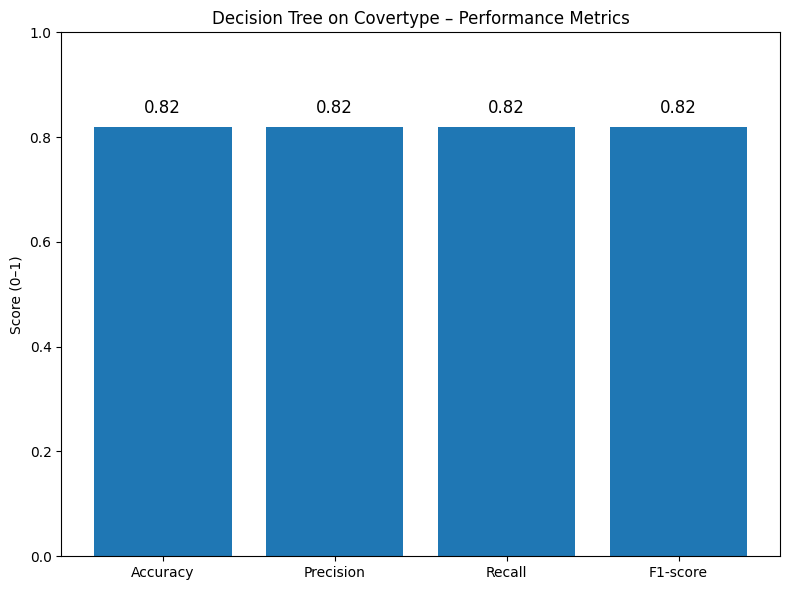

In [8]:
# 5. Visualization of the four metrics
metrics = {
    'Accuracy':  accuracy,
    'Precision': precision,
    'Recall':    recall,
    'F1‐score':  f1
}

names  = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(8,6))
bars = plt.bar(names, values)
plt.ylim(0,1)
plt.title('Decision Tree on Covertype – Performance Metrics')
plt.ylabel('Score (0–1)')

# annotate bars with numeric values
for bar, val in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        val + 0.02,
        f"{val:.2f}",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.tight_layout()
plt.savefig('decision_tree_performance.png', dpi=300)  # high-res for paper
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Your mapping
class_names = {
    1: "Lodgepole Pine",
    2: "Spruce/Fir",
    3: "Ponderosa Pine",
    4: "Cottonwood/Willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz"
}

# Ensure labels and names are in the correct order
labels = list(class_names.keys())
names  = [class_names[label] for label in labels]

# Compute confusion matrices
cm      = confusion_matrix(y_test, y_pred, labels=labels)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

def plot_cm(matrix, title, filename, normalize=False):
    plt.figure(figsize=(8, 6))
    im = plt.imshow(matrix, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(np.arange(len(labels)), names, rotation=45, ha='right')
    plt.yticks(np.arange(len(labels)), names)

    # Annotate each cell with the numeric value
    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            plt.text(
                j, i,
                format(val, fmt),
                ha='center', va='center',
                color='white'
            )

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

# Plot & save both versions
plot_cm(cm,      "Confusion Matrix (Raw Counts)",       "confusion_matrix_raw_annotated.png",   normalize=False)
plot_cm(cm_norm, "Decision Tree Normalized Confusion Matrix", "confusion_matrix_norm_annotated.png", normalize=True)

print("Saved: confusion_matrix_raw_annotated.png and confusion_matrix_norm_annotated.png")

Saved: confusion_matrix_raw_annotated.png and confusion_matrix_norm_annotated.png
